In [1]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler

In [2]:
class AttentionEncoder(nn.Module):
    def __init__(self, input_size, T, hidden_size, dropout):
        super(AttentionEncoder, self).__init__()
        self.input_size = input_size
        self.T = T
        self.hidden_size = hidden_size
        self.dropout = dropout
        
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, dropout = self.dropout)
        # define attention layer
        self.linear = nn.Linear(self.T + self.hidden_size * 2, self.T, False)
        self.linear2 = nn.Linear(self.T, 1, False)
        
    def forward(self, x):
        # note that input x has dimension of T * batch * input_size, and hidden is batch * hidden_size
        batch_size = x.shape[1]
        h = self.init_state(batch_size, self.hidden_size)
        c = self.init_state(batch_size, self.hidden_size)
        h_out=torch.zeros(self.T, batch_size, self.hidden_size, device = device)
        
        for i in range(self.T):
            # first calculate input attention
            concat_hc = torch.cat((h, c), 2).permute(1,0,2).repeat(1, self.input_size, 1)
            # concat_hc has a size of batch_size * input_size * 2 hidden_size
            out = self.linear(torch.cat((concat_hc, x.permute(1, 2, 0)), 2))
            # out has a dimension of (batch_size*input_size) * T
            weight = self.linear2(torch.tanh(out)).view(batch_size, self.input_size)
            weight = torch.softmax(weight, 1)
            # weight has a size of batch * input_size
            
            # update h and c
            _, new_state = self.lstm((x[i] * weight).unsqueeze(0), (h, c))
            h, c = new_state
            h_out[i] = h[0]
        return h_out
    def init_state(self, batch_size, hidden_size):
        return torch.zeros(1, batch_size, hidden_size, device=device)
    def init_weight(self, T, batch_size, input_size):
        return torch.zeros(1, T, batch_size, input_size, device=device)

In [3]:
class AttentionDecoder(nn.Module):
    def __init__(self, input_size, T, hidden_size, dropout):
        super(AttentionDecoder, self).__init__()
        # input size = 1 + m, here m is h state dimension
        self.input_size = input_size
        self.T = T
        self.hidden_size = hidden_size
        self.dropout = dropout
        
        # use nn.ModuleList for customized sequential layers
        self.lstm = nn.LSTM(1, self.hidden_size, dropout = self.dropout)
        # define attention layers which are linear of tanh layers
        self.linear = nn.Linear(self.input_size - 1 + self.hidden_size * 2, self.input_size - 1, False)
        self.v = nn.Linear(self.input_size - 1, 1, False)
        self.linear2 = nn.Linear(self.input_size, 1)
        self.linear3 = nn.Linear(self.hidden_size + self.input_size - 1, self.hidden_size)
        self.linear4 = nn.Linear(self.hidden_size, 1)
    def forward(self, y, h):
        batch_size = y.shape[1]
        d=self.init_state(batch_size,self.hidden_size)
        s=self.init_state(batch_size,self.hidden_size)
        # note that input y: T * batch * 1, h: T * batch * m, hidden state d: batch * hidden_size
        for i in range(self.T):
            # first calculate temporal attention on h from encoder
            concat_ds = torch.cat((d, s), 2).permute(1, 0, 2).repeat(1, self.T, 1)
            out = self.linear(torch.cat((concat_ds, h.permute(1, 0, 2)), 2))
            weight = self.v(torch.tanh(out)).view(batch_size, self.T)
            weight = torch.softmax(weight, 1)
            weight = weight.unsqueeze(1)
            # new h after temporal attention, batch_size * hidden
            new_h = torch.bmm(weight, h.permute(1, 0, 2)).squeeze(1)
            # update d and s
            _, new_state = self.lstm((self.linear2(torch.cat((y[i], new_h), 1))).unsqueeze(0), (d, s))
            d, s = new_state
    
        y_out = self.linear4(self.linear3(torch.cat((d.squeeze(0), new_h), 1)))
        return y_out
    def init_state(self, batch_size, hidden_size):
        return torch.zeros(1, batch_size, hidden_size, device=device)
    def init_weight(self, T, batch_size):
        return torch.zeros(1, batch_size, T, device=device)        

In [4]:
def Train(Encoder, Decoder, Train_X, Train_Y, Eval_X, Eval_Y, epoch, param, Encoderoptimizer, Decoderoptimizer, criterion, print_num):
    T, m, p, n, batch_size = param
    n_iter, rem = Train_Y.shape[0]//batch_size, Train_Y.shape[0]%batch_size
    Eval_Loss=[]
    for epoch_num in range(epoch):
        idx = np.random.permutation(Train_Y.shape[0])
        # input_tensor has a size of T * (35100 - T) * (n+1), target_tensor has a size of (35100 - T) * 1
        total_loss = 0
        pre_time = time.time()
        i_last = 0
        for i in range(n_iter):
            batch_idx = idx[i * batch_size:(i + 1) * batch_size]
            y_target = Train_Y[batch_idx].to(device)
            x, y = Train_X[:, batch_idx, :n].to(device), Train_X[:, batch_idx, n:].to(device)
            
            Encoderoptimizer.zero_grad()
            Decoderoptimizer.zero_grad()
            
            h = Encoder(x)
            y_pred = Decoder(y, h)
            loss = criterion(y_pred, y_target)
            loss.backward()
            Encoderoptimizer.step()
            Decoderoptimizer.step()
            total_loss += loss
            
            if (i + 1)%print_num == 0:
                with torch.no_grad():
                    x, y = Eval_X[:, :, :n].to(device), Eval_X[:, :, n:].to(device)
                    h = Encoder(x)
                    y_pred = Decoder(y, h)
                    eval_loss = criterion(y_pred, Eval_Y.to(device))
                    Eval_Loss.append(eval_loss.cpu().numpy())
                print('Epoch = %d, Iter = %5d, Time elapsed = %d s, Loss = %f.' % (epoch_num + 1, i + 1, time.time() - pre_time, total_loss/(i-i_last+1)))
                pre_time = time.time()
                total_loss = 0
                i_last = i + 1
        if rem != 0:
            i = i + 1
            batch_idx = idx[i * batch_size:]
            y_target = Train_Y[batch_idx].to(device)
            x, y = Train_X[:, batch_idx, :n].to(device), Train_X[:, batch_idx, n:].to(device)
            
            Encoderoptimizer.zero_grad()
            Decoderoptimizer.zero_grad()
            
            h = Encoder(x)
            y_pred = Decoder(y, h)
            loss = criterion(y_pred, y_target)
            loss.backward()
            Encoderoptimizer.step()
            Decoderoptimizer.step()
            total_loss += loss
        print('Epoch = %d, Iter = %5d finished, Time elapsed = %d s, Loss = %f.' % (epoch_num + 1, i + 1, time.time() - pre_time, total_loss/(i-i_last+1)))
    return Eval_Loss

In [5]:
def Validate(Encoder, Decoder, Eval_X, Eval_Y, param):
    T, m, p, n, batch_size = param
    with torch.no_grad():
        x, y = Eval_X[:, :, :n].to(device), Eval_X[:, :, n:].to(device)
        h = Encoder(x)
        y_pred = Decoder(y, h)
        loss = criterion(y_pred, Eval_Y.to(device))
    return (y_pred, loss)

In [6]:
class parameter:
    T_grid = [10]
    m_grid = [128]
    batch_size = 128
    epoch = 2
    learning_rate = 0.001
    Train_num = 35100 + 60
    Eval_num = 2700
    Test_num = 2700
    print_num = 50
    dropout = 0

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
config=parameter()
Train_num, Eval_num, Test_num, batch_size = config.Train_num, config.Eval_num, config.Test_num, config.batch_size

data =  pd.read_csv('./nasdaq100/small/nasdaq100_padding.csv').values

percentage = 0
if percentage:
    for i in range(data.shape[0] - 1, 0, -1):
        data[i] = (data[i] - data[i-1])/data[i-1]
    data = data[1:]
scale = StandardScaler().fit(data)
data = scale.transform(data)

datax, datay = torch.from_numpy(data[:,:-1]).float(), torch.from_numpy(data[:, -1]).float().unsqueeze(1)
datax.shape, datay.shape

(torch.Size([40560, 81]), torch.Size([40560, 1]))

Epoch = 1, Iter =    20, Time elapsed = 4 s, Loss = 0.670774.
Epoch = 1, Iter =    40, Time elapsed = 3 s, Loss = 0.418097.
Epoch = 1, Iter =    60, Time elapsed = 3 s, Loss = 0.214275.
Epoch = 1, Iter =    80, Time elapsed = 3 s, Loss = 0.133069.
Epoch = 1, Iter =   100, Time elapsed = 3 s, Loss = 0.079012.
Epoch = 1, Iter =   120, Time elapsed = 2 s, Loss = 0.062698.
Epoch = 1, Iter =   140, Time elapsed = 2 s, Loss = 0.052319.
Epoch = 1, Iter =   160, Time elapsed = 2 s, Loss = 0.045406.
Epoch = 1, Iter =   180, Time elapsed = 2 s, Loss = 0.034269.
Epoch = 1, Iter =   200, Time elapsed = 2 s, Loss = 0.032890.
Epoch = 1, Iter =   220, Time elapsed = 3 s, Loss = 0.028646.
Epoch = 1, Iter =   240, Time elapsed = 2 s, Loss = 0.027316.
Epoch = 1, Iter =   260, Time elapsed = 3 s, Loss = 0.025587.
Epoch = 1, Iter =   275 finished, Time elapsed = 2 s, Loss = 0.023121.
Epoch = 2, Iter =    20, Time elapsed = 3 s, Loss = 0.023491.
Epoch = 2, Iter =    40, Time elapsed = 2 s, Loss = 0.021956.

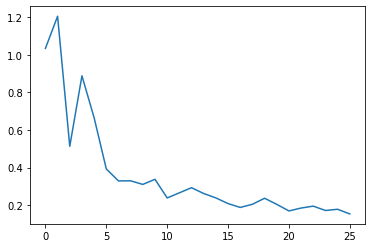

In [8]:
criterion = nn.MSELoss()
print_num = 20
n = datax.shape[1]
loss = np.zeros((len(config.T_grid), len(config.m_grid)))
Model_list=[]
for i, T in enumerate(config.T_grid):
    for j, m in enumerate(config.m_grid):
        param = [T, m, m, n, batch_size]
        data_Y = datay[T:]
        data_X = torch.zeros(T, datay.shape[0] - T, n + 1)
        for index in range(T, datay.shape[0]):
            data_X[:,index-T,:n] = datax[index-T:index]
            data_X[:,index-T,n:] = datay[index-T:index]
        Train_X, Eval_X, Test_X = data_X.split([Train_num - T, Eval_num, Test_num], dim = 1)
        Train_Y, Eval_Y, Test_Y = data_Y.split([Train_num - T, Eval_num, Test_num])
        
        Encoder = AttentionEncoder(n, T, m, dropout = config.dropout).to(device)
        Decoder = AttentionDecoder(1 + m, T, m, dropout = config.dropout).to(device)
        Encoderoptimizer = optim.Adam(Encoder.parameters(), lr=config.learning_rate, weight_decay = 0)
        Decoderoptimizer = optim.Adam(Encoder.parameters(), lr=config.learning_rate, weight_decay = 0)
        # Training
        Eval_loss = Train(Encoder, Decoder, Train_X, Train_Y, Eval_X, Eval_Y, config.epoch, param, Encoderoptimizer, Decoderoptimizer, criterion, print_num)
        plt.figure()
        plt.plot(Eval_loss)
        plt.show()
        Model_list.append([Encoder, Decoder])
        # Eval
        _, loss[i][j] = Validate(Encoder, Decoder, Eval_X, Eval_Y, param)

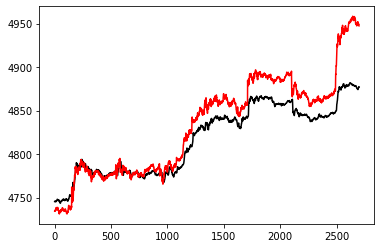

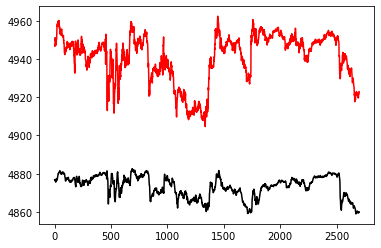

In [9]:
min_idx = np.argmin(loss)
i, j = min_idx//len(config.m_grid), min_idx%len(config.m_grid)
T, m = config.T_grid[i], config.m_grid[j]
param = [T, m, m, n, batch_size]
data_Y = datay[T:]
data_X = torch.zeros(T, datay.shape[0] - T, n + 1)
for index in range(T, datay.shape[0]):
    data_X[:,index-T,:n] = datax[index-T:index]
    data_X[:,index-T,n:] = datay[index-T:index]
Train_X, Eval_X, Test_X = data_X.split([Train_num - T, Eval_num, Test_num], dim = 1)
Train_Y, Eval_Y, Test_Y = data_Y.split([Train_num - T, Eval_num, Test_num])

# Test
Encoder, Decoder = Model_list[min_idx]
# first see Eval data prediction
y_pred_Test, loss_Test = Validate(Encoder, Decoder, Eval_X, Eval_Y, param)
plt.figure()
plt.plot(scale.inverse_transform(y_pred_Test.cpu().repeat(1,82).numpy())[:,-1],'k',scale.inverse_transform(Eval_Y.repeat(1,82).numpy())[:,-1],'r')
# see the prediction of new data
y_pred_Test, loss_Test = Validate(Encoder, Decoder, Test_X, Test_Y, param)
plt.figure()
plt.plot(scale.inverse_transform(y_pred_Test.cpu().repeat(1,82).numpy())[:,-1],'k',scale.inverse_transform(Test_Y.repeat(1,82).numpy())[:,-1],'r')